In [29]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import time
import torch
import tiktoken
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split
from src.train_classifier import (
    calc_precision_loader,
    calc_loss_loader,
    calc_accuracy_loader,
    train_classifier_simple,
)
from src.loader import SpamSMSDataset
from src.utils import value_counts

tokenizer = tiktoken.get_encoding("gpt2")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load data

In [31]:
file_path = Path('data/SMSSpamCollection.tsv')

### Create loader

In [32]:
full_dataset = SpamSMSDataset(file_path, tokenizer, max_length=120)

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, lengths=[0.6, 0.1, 0.3]
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=8,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=8,
    shuffle=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=8,
    shuffle=True,
)

### Number of batches

In [33]:

print(f"number of training batches: {len(train_loader)}")
print(f"number of validation batches: {len(val_loader)}")
print(f"number of test batches: {len(test_loader)}")

number of training batches: 418
number of validation batches: 70
number of test batches: 209


### Class distribution

In [34]:

train_label_normalized = value_counts(train_loader, normalize=True)
val_label_normalized = value_counts(val_loader, normalize=True)
test_label_normalized = value_counts(test_loader, normalize=True)

print(f"class distribution in training loader: {train_label_normalized}")
print(f"class distribution in validation loader: {val_label_normalized}")
print(f"class distribution in test loader: {test_label_normalized}")

class distribution in training loader: {0: 0.8702153110047847, 1: 0.1297846889952153}
class distribution in validation loader: {0: 0.8473967684021544, 1: 0.1526032315978456}
class distribution in test loader: {0: 0.8635547576301615, 1: 0.13644524236983843}


### Load OpenAI pretrained GPT2 model from HuggingFace

In [35]:
import torch
from transformers import GPT2Model
from src.model import MODEL_ARCHITECTURES, GPTModel
from src.utils import load_weights

# Choose the default architecture
base_configs = MODEL_ARCHITECTURES['gpt2-small']
custom_configs = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,  # Dropout rate
    "qkv_bias": True,  # Query-Key-Value bias
}

model_configs = base_configs | custom_configs

# Create a model sketch
gpt = GPTModel(model_configs)

# Load weights from HuggingFace's model
gpt_pretrained = GPT2Model.from_pretrained("openai-community/gpt2", cache_dir="checkpoints")
load_weights(gpt, gpt_pretrained, model_configs)

# Move to GPU if available
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_decoders): Sequential(
    (0): TransformerDecoder(
      (multi_head_attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (norm_layer1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm_layer2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (feed_foward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      

### Check if the model can generate reasonable text

In [36]:
from src.utils import generate_sequence
from src.token import token_ids_to_text, text_to_token_ids

text_1 = "Every effort moves you"

token_ids = generate_sequence(
    model=gpt,
    idx=text_to_token_ids(text_1, tokenizer).to(device),
    max_new_tokens=15,
    context_size=model_configs['context_length']
)

print("========================== Example 1 ==========================\n")
print(token_ids_to_text(token_ids, tokenizer))

print("\n========================== Example 2 ==========================\n")

text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':" 
    " 'You are a winner you have been specially" 
    " selected to receive $ 1000 cash or a $ 2000 award.'"
)

token_ids = generate_sequence(
    model=gpt,
    idx=text_to_token_ids(text_2, tokenizer).to(device),
    max_new_tokens=23,
    context_size=model_configs['context_length']
)

print(token_ids_to_text(token_ids, tokenizer))

========================== Example 1 ==========================

Every effort moves you forward.

The first step is to understand the importance of your work

========================== Example 2 ==========================

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $ 1000 cash or a $ 2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


### Adjust the model output to fit a classification setup

In [37]:
num_classses = 2

gpt.out = torch.nn.Linear(
    in_features=model_configs['emb_dim'],
    out_features=num_classses
).to(device)

# Make the last transformer block trainable
for param in gpt.transformer_decoders[-1].parameters():
    param.requires_grad = True

# Make the last normalization block trainable
for param in gpt.final_norm.parameters():
    param.requires_grad = True

### Check the new output format

In [38]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0).to(device)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

with torch.no_grad():
    outputs = gpt(inputs)
print("Outputs:\n", outputs)
print("Outpus dimensions:", outputs.shape)

Inputs: tensor([[5211,  345,  423,  640]], device='cuda:0')
Inputs dimensions: torch.Size([1, 4])
Outputs:
 tensor([[[1.3114, 1.6442],
         [4.0159, 3.1449],
         [2.1110, 3.9480],
         [2.4801, 4.5076]]], device='cuda:0')
Outpus dimensions: torch.Size([1, 4, 2])


### Check model performance without fine-tunning it

In [39]:
num_batches = 50

train_accuracy = calc_accuracy_loader(
    train_loader, gpt, device, num_batches=num_batches
)
val_accuracy = calc_accuracy_loader(
    val_loader, gpt, device, num_batches=num_batches
)
test_accuracy = calc_accuracy_loader(
    test_loader, gpt, device, num_batches=num_batches
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Validation accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 12.25%
Validation accuracy: 15.00%
Validation accuracy: 13.75%


In [40]:
train_precision = calc_precision_loader(
    train_loader, gpt, device, num_batches=num_batches
)
val_precision = calc_precision_loader(
    val_loader, gpt, device, num_batches=num_batches
)
test_precision = calc_precision_loader(
    test_loader, gpt, device, num_batches=num_batches
)

print(f"Training precision: {train_precision*100:.2f}%")
print(f"Validation precision: {val_precision*100:.2f}%")
print(f"Test precision: {test_precision*100:.2f}%")

Training precision: 13.75%
Validation precision: 16.00%
Test precision: 10.00%


In [41]:
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, gpt, device, num_batches=num_batches
    )
    val_loss = calc_loss_loader(val_loader, gpt, device, num_batches=num_batches)
    test_loss = calc_loss_loader(test_loader, gpt, device, num_batches=num_batches)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 3.755
Validation loss: 3.609
Test loss: 3.639


### Fine tune!

In [42]:
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_precision, val_precision, examples_seen = (
    train_classifier_simple(
        gpt,
        train_loader,
        val_loader,
        optimizer,
        device,
        num_epochs=num_epochs,
        eval_freq=50,
        eval_iter=10,
        tokenizer=tokenizer,
    )
)

end_time = time.time()
execution_time_minuter = (end_time - start_time) / 60

print(f"Training completed in {execution_time_minuter: .2f} minutes.")

Ep 1 (Step 000000): Train loss 1.852, Val loss 1.815
Ep 1 (Step 000050): Train loss 0.246, Val loss 0.236
Ep 1 (Step 000100): Train loss 0.266, Val loss 0.583
Ep 1 (Step 000150): Train loss 0.069, Val loss 0.079
Ep 1 (Step 000200): Train loss 0.052, Val loss 0.105
Ep 1 (Step 000250): Train loss 0.058, Val loss 0.096
Ep 1 (Step 000300): Train loss 0.069, Val loss 0.058
Ep 1 (Step 000350): Train loss 0.043, Val loss 0.071
Ep 1 (Step 000400): Train loss 0.042, Val loss 0.083
Training accuracy: 97.50% | Validation accuracy: 96.25%
Ep 2 (Step 000450): Train loss 0.005, Val loss 0.140
Ep 2 (Step 000500): Train loss 0.072, Val loss 0.028
Ep 2 (Step 000550): Train loss 0.009, Val loss 0.008
Ep 2 (Step 000600): Train loss 0.123, Val loss 0.008
Ep 2 (Step 000650): Train loss 0.066, Val loss 0.046
Ep 2 (Step 000700): Train loss 0.066, Val loss 0.026
Ep 2 (Step 000750): Train loss 0.060, Val loss 0.101
Ep 2 (Step 000800): Train loss 0.025, Val loss 0.100
Training accuracy: 100.00% | Validation acc

In [43]:
torch.save({
    "model_state_dcit": gpt.state_dict(),
    "optimize_state_dict": optimizer.state_dict(),
    },
    "data/model_and_optimizer.pth"
)

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
def to_cpu(value):
    if isinstance(value, torch.tensor):
        return tensor.to('cpu')
    return value

def tensors_to_cpu(tensor_list):
    return [to_cpu(tensor) for tensor in tensor_list]

In [46]:
def plot_values(epochs_seen, examples_seen, train_values, val_values, label='loss'):
    fig, ax1 = plt.subplots(figsize=(5,3))

    sns.lineplot(x=epochs_seen, y=train_values, label=f"Training {label}", ax=ax1)
    sns.lineplot(x=epochs_seen, y=val_values, label=f"Validation {label}", linestyle="-.", ax=ax1)

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    sns.lineplot(x=examples_seen, y=train_values, alpha=0, ax=ax2)
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


In [47]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

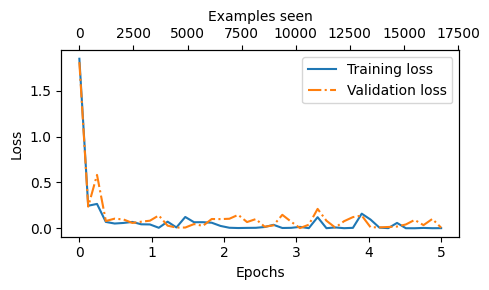

In [48]:
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

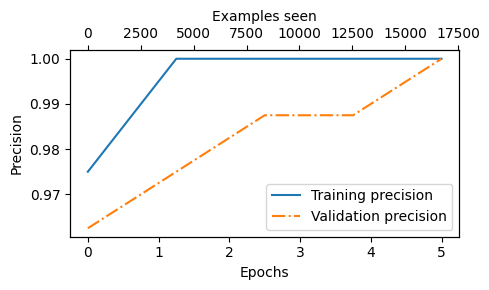

In [49]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_precision))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_precision))
plot_values(epochs_tensor, examples_seen_tensor, train_precision, val_precision, label='precision')